# What is JAX?
Ben Moseley
9 December 2022

This material has mostly been copied from the official JAX documentation:
- https://jax.readthedocs.io/en/latest/notebooks/quickstart.html

And these blog posts:
- https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/
- https://kidger.site/thoughts/jax-vs-julia/


<img src="JAX-overview.svg" width=40%>

> JAX and Julia are unquestionably the current state-of-the-art frameworks for autodifferentiation, scientific computing, and ML computing

Compared to PyTorch:
- JAX is *much faster* than pytorch for scientific computing (less interpreter overhead/ better jit) - particularly for e.g. differential equation solvers
- JAX is *more feature-complete* for scientific computing - e.g. more advanced autodifferentiation

## Programming paradigm


### Compilation

Julia and JAX are both based on JIT compilation - compiled and optimised down to efficient machine code the first time it is run.

The first run of the code (function) is slower, whilst subsequent runs are fast.

Compared to Julia:
- JAX can have slowish compilation speeds for the python interpreter to chug through, compared to Julia
- JAX is a python package (DSL), whilst Julia is a programming language. This means we have to refer to the `jax` package rather than using native synatax such as `for` loops, for some use cases
- JAX appears more reliable (in terms of documentation, gradient bugs/ code reliability, professionalism), and array indexing is much nicer; it mirrors numpy

JAX relies on JIT XLA to make this compiled code fast (*whole program compiler* designed for linear algebra, and not just single operations): XLA (developed by Google) is the DNA and foundation of JAX, and includes many optimisations including *kernel fusion*.

Note this can place limitations on the types of code (functions) that you can jit (see below).

Since all JAX operations are implemented in terms of operations in XLA, JAX has a *unified language* for computation that allows it to run seamlessly across CPU, TPU, and GPU.

Compared to PyTorch:
- JAX uses static graph creation and compilation, whilst PyTorch is dynamic

### Composible function transforms

JAX (and Julia) uses *homoiconicity* - the property of being able to represent *code as data*, or more precisely, the program's internal representation can be inferred just by reading the program itself.

> This allows you to *write code that modifies other code*. E.g. backpropagation: reriting your code to be evaluated in reverse order. Aka metaprogramming (other programs as input data -> a program can read, generate, analyse and transform other programs). This is known as a *program transformation* (`jaxprs` deals with this) including: 
> - JIT compilation
> - Autodifferentiation
> - Automatic parallelisation
> - Automatic vectorisation

Jax provides four main transforms (functions to functions) which can be composed *arbitrarily*:
1. `grad()` for evaluating the gradient of a function, as well as `jacfwd()` and `jacrev()` and jvp/vjp. Forward/reverse, composed arbitrarily to any order
2. `vmap()` for automatic vectorisation (*beyond simple vectorisation*, to arbitrary Python functions)
3. `pmap()` for easy parallelisation (across cores/GPUs)
4. `jit()` for compilation

> JAX USP: High performance numerical computing library which combines:
> - JIT XLA compilation
> - *composable transformations* of Python+NumPy programs (/functions) (differentiate, vectorize, JIT to GPU/TPU, and more)

Note deep learning is just a small subset of what JAX can do (see figure)!

Behind the scenes of JAX: https://jax.readthedocs.io/en/latest/autodidax.html

Compared to PyTorch:
- Fundamentally JAX is a stack of interpreters, that go through and progressively re-write your program -- e.g. mapping over batch dimensions, take gradients etc. -- before offloading all the actual computation to XLA
- In torch, the graph is built in the forward pass, whilst gradients are calculated in the backwards pass, for a certain point in the function. In JAX, a new *function* is created which directly computes the gradient of any input function
- This appears more flexible and combined with JIT XLA e.g. allows more efficient computation of gradient-per-sample and Hessians and other more complex autodiff use cases
- Both frameworks can differentiate through complex control flows

## CPU / GPU support

JAX appears to fully support GPUs when using the composable transforms above. 

JAX provides a near-identical numpy version, which works very easily on GPUs and TPUs. This alone can justify the use of JAX!

JAX for TPU is absolutely seamless.

JAX is not optimised for CPU computing ("accelerator first") - so numpy may be faster for some cases.

## Development

JAX is being actively and professionally developed, although still officially experimental. Hit the scene in 2018, used by many Google/DeepMind papers now. Not Windows compatible.


## What's the catch?

### Functional programming

The catch of composible program transforms and JIT XLA is that this restricts JAX to work only for *functionally pure* programs: we must be able to write in terms of *pure functions* (and not objects or other more complex control flows). 

All the input data is passed through the function parameters, all the results are output through the function results. A pure function will always return the same result if invoked with the same inputs.

Another way of saying this is that the function must have *referential transparency* - a pure function can be replaced with the result of its evaluation at any time, and the program cannot tell the difference. 

The function:
- cannot have control flow statements that depend on values of variables
- cannot access variables outside of its scope
- cannot have an I/O stream (so no printing, or accessing the time)
- cannot have a mutable function as argument

Other limitations:
- JAX *cannot modify arrays in-place*.
- JAX requires *explicit RNG handling*.
- errors are *not* raised for out-of-bounds indexing. (!) Think of this as undefined behaviour.
- It is not recommended to use iterators in any JAX function you want to `jit`.


Otherwise, there may be some !! untracked side effects !!

> Make sure you are dilligent and understand functional programming / JAX pitfalls. 

Jax is lower-level than PyTorch.

## SciML

JAX is brilliant for large-scale, complex, hybrid modeling, and soley for hardware acceleration too!

## Deep learning

JAX is roughly equivalent to just the `torch` namespace; you need to choose from various external libraries for building neural networks (equivalent to the `torch.nn` namespace). Check out `Equinox` - simple/transparent/general/designed with DEs in mind/ flexible function parameterisation. `Flax` (Google Brain) and `Haiku` (DeepMind) are most popular. `Optax` is good for optimisers.

JAX is excellent for non-standard modelling, and training on TPUs! For standard training, PyTorch is probably better for now.


In [1]:
import jax
import jax.numpy as jnp
from jax import lax
from jax import grad, jit, vmap, pmap,  jacfwd, jacrev
from jax import random
from jax import device_put, make_jaxpr
from jax import tree_util
from jax.scipy.special import logsumexp
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

# Quickstart

## Simple arrays

- JAX provides a NumPy-inspired interface `jax.numpy` for convenience.
- Through duck-typing, JAX arrays can often be used as drop-in replacements of NumPy arrays.
- Unlike NumPy arrays, JAX arrays are always immutable.

In [2]:
# generate random data
key = random.PRNGKey(0)
x = random.normal(key, (10,))# JAX requires explicit RNG handling (see below)
print(x, x.shape, type(x))

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ] (10,) <class 'jaxlib.xla_extension.DeviceArray'>


In [3]:
# matrix multiply
x = random.normal(key, (100, 120), dtype=jnp.float32)
x@x.T

DeviceArray([[129.95944   ,   7.6958685 ,   8.772064  , ...,
                6.3571653 ,   2.3293855 ,  -8.627743  ],
             [  7.6958685 , 123.0987    ,   1.9893165 , ...,
                0.45828867,  -9.394791  , -15.0048275 ],
             [  8.772064  ,   1.9893165 ,  87.803734  , ...,
              -21.56633   ,  16.132122  ,  -5.47758   ],
             ...,
             [  6.3571653 ,   0.45828724, -21.566336  , ...,
              126.38751   ,  -2.683978  ,   2.3173656 ],
             [  2.3293874 ,  -9.394792  ,  16.13212   , ...,
               -2.683978  , 120.720474  ,   1.6255394 ],
             [ -8.627744  , -15.004827  ,  -5.4775796 , ...,
                2.3173656 ,   1.6255394 ,  87.94435   ]], dtype=float32)

The big difference is that JAX arrays are *immutable*!

This is because allowing mutation of variables in-place makes program analysis and transformation difficult

In [4]:
x = jnp.arange(10)
try:
    x[0] = 10
except Exception as e:
    print(e)

'<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


For updating individual elements, JAX provides an indexed update syntax that returns an updated out-of-place *copy*
(a functional array update).

However, inside jit-compiled code, if the input value `x` of `x.at[idx].set(y)` is not reused, the compiler will optimize the array update to occur in-place

In [5]:
x = x.at[0].set(10)
print(x)
x = x.at[::2].add(7)
print(x)

[10  1  2  3  4  5  6  7  8  9]
[17  1  9  3 11  5 13  7 15  9]


### Random numbers

JAX implements an explicit PRNG where randomness is handled by *explicitly* passing and iterating a PRNG state.

JAX uses a modern Threefry counter-based PRNG that’s *splittable*. That is, its design allows us to *fork* the PRNG state into new PRNGs for use with parallel stochastic generation.

This gives much better control over PRNG for complex multi threaded/process/device programs.

Note: JAX’s random functions produce pseudorandom numbers from the PRNG state, but *do not* change the state!

Instead, we split the PRNG to get usable subkeys every time we need a new pseudorandom number:

In [6]:
key = random.PRNGKey(0)# key represents state and is passed as first argument
print(random.normal(key, shape=(1,)))# does not change the state (!)
print(random.normal(key, shape=(1,)))

key, subkey = random.split(key)# propagates the key, and produces a subkey for use
print(random.normal(subkey, shape=(1,)))

key, *subkeys = random.split(key, 4)# generate multiple subkeys at once
for subkey in subkeys:
    print(random.normal(subkey, shape=(1,)))

[-0.20584226]
[-0.20584226]
[-1.2515389]
[1.4544677]
[-0.49327764]
[-0.39947626]


### `jax.numpy` vs `jax.lax`

- jax.numpy is a high-level wrapper that provides a familiar interface.
- jax.lax is a lower-level API that is stricter and often more powerful.

If you look at the source of `jax.numpy`, you’ll see that all the operations are eventually expressed in terms of functions defined in `jax.lax`.

For example, while `jax.numpy` will implicitly promote arguments to allow operations between mixed data types, `jax.lax` will not.

At their heart, all `jax.lax` operations are Python wrappers for operations in XLA.

Every JAX operation is eventually expressed in terms of these fundamental XLA operations, which is what enables JIT compilation.

In [7]:
lax.add(jnp.float32(1), 1.0)

DeviceArray(2., dtype=float32)

## Putting onto device

In JAX, the computation follows data placement. JAX arrays have two placement properties: 1) the device where the data resides; and 2) whether it is committed to the device or not (the data is sometimes referred to as being sticky to the device).

By default, JAX arrays are placed uncommitted on the default device (`jax.devices()[0]`), which is the first GPU or TPU by default. If no GPU or TPU is present, `jax.devices()[0]` is the CPU. The default device can temporarily overridden with the `jax.default_device()` context manager, or set for the whole process by setting the environment variable `JAX_PLATFORMS` or the `absl flag --jax_platforms` to `“cpu”`, `“gpu”`, or `“tpu”`

Computations involving uncommitted data are performed on the default device and the results are uncommitted on the default device.

Data can also be placed explicitly on a device using `jax.device_put()` with a device parameter, in which case the data becomes committed to the device.

Computations involving some committed inputs will happen on the committed device and the result will be committed on the same device. Invoking an operation on arguments that are committed to more than one device will raise an error.

`jax.device_put(jnp.zeros(...)`, `jax.devices()[1])` or similar will actually create the array of zeros on `jax.devices()[1]`, instead of creating the array on the default device then moving it. This is thanks to some laziness in array creation, which holds for all the constant creation operations (ones, full, eye, etc).

Thus, JAX runs transparently on the GPU or TPU (falling back to CPU if you don’t have one). 

Use `device_put` to put *and keep* something on a device. It only copies values back to the CPU when they’re needed for printing, plotting, saving to disk, branching, etc.




In [8]:
print(jax.devices())

x = device_put(x)
x.device()

[CpuDevice(id=0)]


CpuDevice(id=0)

## Asynchronous dispatch

JAX uses asynchronous dispatch to hide Python overhead. When an operation such as `jnp.dot(x, x)` is executed, JAX does not wait for the operation to complete before returning control to the Python program.

Only if we actually inspect the value of the array from the host, for example by printing it or by converting it into a plain old `numpy.ndarray` will JAX force the Python code to wait for the computation to complete.

One can also call the `.block_until_ready()` method on a `DeviceArray` to wait for the computation to complete.

Asynchronous dispatch is useful since it allows Python code to “run ahead” of an accelerator device, keeping Python code out of the critical path.


In [9]:
(x@x.T).block_until_ready()

DeviceArray(1050, dtype=int32)

## How JAX transforms work

Conceptually, one can think of JAX transformations as first trace-specializing the Python function to be transformed into a small and well-behaved intermediate form that is then interpreted with transformation-specific interpretation rules. One of the reasons JAX can pack so much power into such a small software package is that it starts with a familiar and flexible programming interface (Python with NumPy) and it uses the actual Python interpreter to do most of the heavy lifting to distill the essence of the computation into a simple statically-typed expression language with limited higher-order features. That language is the `jaxpr` language.

It is important to point out that not all JAX transformations literally materialize a `jaxpr` as described above; some, e.g., differentiation or batching, will apply transformations incrementally during tracing. 


In the previous section, we discussed that JAX allows us to transform Python functions. This is done by first converting the Python function into a simple intermediate language called jaxpr. The transformations then work on the `jaxpr` representation.

We can show a representation of the `jaxpr` of a function by using `jax.make_jaxpr`:

In [10]:
global_list = []

def log2(x):
    global_list.append(x)# jax functions shouldn't modify external variables - tracing does not record side effects!!
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


Importantly, note how the jaxpr *does not capture the side-effect* of the function: there is nothing in it corresponding to global_list.append(x). This is a feature, not a bug: 

> JAX is designed to understand side-effect-free (a.k.a. functionally pure) code.

> In order to use jaxpr and tracing, JAX code must be *functionally pure*.

This means that functions must not have *side-effects*:

A side-effect is any effect of a function that doesn’t appear in its output.

Of course, impure functions can still be written and even run, but JAX gives no guarantees about their behaviour once converted to jaxpr. However, as a rule of thumb, you can expect (but shouldn’t rely on) the side-effects of a JAX-transformed function to run once (during the first call), and never again. This is because of the way that JAX generates jaxpr, using a process called ‘tracing’.

Any such side-effects will only be executed once, when the python version of the function is run during compilation. These side-effects will not be executed by the compiled function on subsequent runs.

When tracing, JAX wraps each argument by a tracer object. These tracers then record all JAX operations performed on them during the function call (which happens in regular Python). Then, JAX uses the tracer records to reconstruct the entire function. The output of that reconstruction is the jaxpr. Since the tracers do not record the Python side-effects, they do not appear in the jaxpr. However, the side-effects still happen during the trace itself.

Note: the Python `print()` function is not pure: the text output is a side-effect of the function. Therefore, any `print()` calls will only happen during tracing, and will not appear in the jaxpr.

Of course, it’s possible to mix side-effectful Python code and functionally pure JAX code, and we will touch on this more later. As you get more familiar with JAX, you will learn how and when this can work. As a rule of thumb, however, any functions intended to be transformed by JAX should avoid side-effects, and the JAX primitives themselves will try to help you do that.

A key thing to understand is that jaxpr captures the function as executed on the parameters given to it. For example, if we have a conditional, jaxpr will only know about the branch we take:

In [11]:
def log2_if_rank_2(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.0)
        return ln_x / ln_2
    else:
        return x

print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


In [12]:
w = 2

def m(x):
    return w*x# be very careful with referencing external variables
jit_m = jit(m)

print(jax.make_jaxpr(m)(1))

for i in range(3):
    w += 1
    print(jit_m(1))

{ lambda ; a:i32[]. let b:i32[] = mul 2 a in (b,) }
3
3
3


## Using `jit()`

By default, JAX executes operations to the GPU/CPU *one at a time*, in sequence. If we have a sequence of operations, we can use the `@jit` decorator to *compile and optimise multiple operations together* using XLA (kernel fusion).

The fact that all JAX operations are expressed in terms of XLA allows JAX to use the XLA compiler to execute blocks of code very efficiently.

This is super fast (at the cost of a slower first run)!!

In [13]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)
print(selu_jit)

x = random.normal(key, (100,))

%timeit selu(x).block_until_ready()

# note that selu_jit is compiled the first time it is called, and cached thereafter
%timeit selu_jit(x).block_until_ready()


# even faster than numpy for this one! (fused kernels!)
def fn(x):
    return x + x*x + x*x*x

jax_fn = jit(fn)

x = np.random.randn(1000, 1000).astype(dtype='float32')
%timeit fn(x)

x = jnp.array(x)
%timeit jax_fn(x).block_until_ready()

<CompiledFunction of <function selu at 0x7f96e6c552d0>>
46.7 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.68 µs ± 73.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.46 ms ± 59.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
532 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### How does JIT work?

To get a view of your Python code that is valid for many different argument values, JAX *traces* it on abstract values that represent sets of possible inputs. There are multiple different levels of abstraction, and different transformations use different abstraction levels.

By default, jit traces your code on the `ShapedArray` abstraction level, where each abstract value represents the set of all array values with a fixed shape and dtype.

This recorded sequence of computations can then be efficiently applied within XLA to new inputs *with the same shape and dtype*, without having to re-trace the Python code.

Note other abstraction levels can be used - see guide.

There are also more advanced control flow primitives in jax you can use to help avoid re-compilation, like `lax.cond`, `lax.scan`, `lax.while_loop` and `lax.fori_loop` - see guide.

In [14]:
@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

# When we call the compiled function again on matching inputs, no re-compilation is  required 
# and nothing is printed because the result is computed in compiled XLA rather than in Python
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

# but if shapes (or types) change, we must re-compile
x3 = np.random.randn(5, 6)
y3 = np.random.randn(6)
f(x3, y3)

# but original compilation is still cached!!
f(x, y)

# The extracted sequence of operations is encoded in a JAX expression, or jaxpr for short. To view it:
def f(x, y):
    return jnp.dot(x + 1, y + 1)
print(make_jaxpr(f)(x, y))
print(make_jaxpr(jit(f))(x, y))

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>
Running f():
  x = Traced<ShapedArray(float32[5,6])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[6])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=0/1)>
{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] c d
  in (e,) }
{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3] = xla_call[
      call_jaxpr={ lambda ; d:f32[3,4] e:f32[4]. let
          f:f32[3,4] = add d 1.0
          g:f32[4] = add e 1.0
          h:f32[3] = dot_general[
            dimension_numbers=(((1,), (0,)), ((), ()))
            precisi

### JIT limitations

Importantly, JIT compiling imposes restrictions on JAX code.

In particular (for `ShapedArray` abstraction), it requires *array shapes* to be *static & known* at compile time:

In [15]:
def get_negatives(x):
    return x[x < 0]
try:
    jit(get_negatives)(jnp.arange(10))
except Exception as e:
    print(e)

Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError


This crashes because the function generates an array whose shape is not known at compile time: the size of the output depends on the values of the input array, and so it is not compatible with JIT.

Likewise, *control flow* statements in the function cannot depend on *traced values*, as JIT compilation is done without information on the content (values) of the array:

In [16]:
def f(x):
    if x > 0:
        return x
    else:
        return 2 * x
f_jit = jit(f)
try:
    f_jit(10)
except Exception as e:
    print(e)

Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function f at /var/folders/6p/mdzn2wk57nq35tz4bgfd63300000gp/T/ipykernel_67556/2320181375.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError


Finally, jitted functions must be *pure*. (see above!!)

### Static variables/ operations

If there are variables that you would not like to be traced, they can be marked as static for the purposes of JIT compilation.

Note that calling a JIT-compiled function with a different static argument results in re-compilation, so the function still works as expected:

In [17]:
@partial(jit, static_argnums=(1,))
def f(x, neg):
    print("compiling!")
    return -x if neg else x

print(f(1, True))
print(f(1, False))

compiling!
-1
compiling!
1


Note `static_argnums` relies on the hash of the object to determine whether it has changed between calls.
Lists and arrays aren't hashable (but tuples and ints are!)

Operations can also be made static.

A useful pattern is to use `numpy` for operations that you want to be static, and `jax.numpy` for operations that you want to be traced:

In [18]:
x = jnp.ones((2, 3))

@jit
def f(x):
    return x.reshape(jnp.array(x.shape).prod())
# although x is traced, x.shape is a static value. However, when we use jnp.array and jnp.prod,
# it becomes a traced value, at which point it cannot be used in a function like reshape() that 
# requires a static input (remember: jit requires array shapes to be static and known)

try:
    f(x)
except Exception as e:
    print(e)

@jit
def f(x):
    return x.reshape((np.prod(x.shape),))# use numpy instead to make sure a static value is passed
f(x)

Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.


DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

### When to use JIT?

`jax.jit` introduces some overhead itself. Therefore, it usually only saves time if the compiled function is complex and you will run it numerous times. Fortunately, this is common in machine learning, where we tend to compile a large, complicated model, then run it for millions of iterations.

Generally, you want to jit the largest possible chunk of your computation; ideally, the *entire update step*. This gives the compiler maximum freedom to optimise.

## Using `grad()`

Taking derivatives is as easy as calling `grad()`. `grad()` and `jit()` compose and can be mixed arbitrarily.

`grad()` works for scalar-valued function

In [19]:
help(grad)

Help on function grad in module jax._src.api:

grad(fun: 'Callable', argnums: 'Union[int, Sequence[int]]' = 0, has_aux: 'bool' = False, holomorphic: 'bool' = False, allow_int: 'bool' = False, reduce_axes: 'Sequence[AxisName]' = ()) -> 'Callable'
    Creates a function that evaluates the gradient of ``fun``.
    
    Args:
      fun: Function to be differentiated. Its arguments at positions specified by
        ``argnums`` should be arrays, scalars, or standard Python containers.
        Argument arrays in the positions specified by ``argnums`` must be of
        inexact (i.e., floating-point or complex) type. It
        should return a scalar (which includes arrays with shape ``()`` but not
        arrays with shape ``(1,)`` etc.)
      argnums: Optional, integer or sequence of integers. Specifies which
        positional argument(s) to differentiate with respect to (default 0).
      has_aux: Optional, bool. Indicates whether ``fun`` returns a pair where the
        first element is c

<class 'function'> <class 'function'> <class 'function'>
<function tanh at 0x7f96e86bc790> <function tanh at 0x7f96e86bca60> <function tanh at 0x7f96e86bcc10>


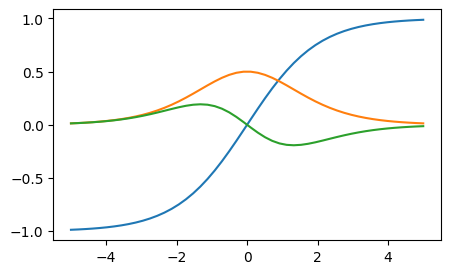

In [20]:
def tanh(x):
    return (1.0 - jnp.exp(-x))  / (1.0 + jnp.exp(-x))

# get derivative functions
tanh_d = grad(tanh)# this is a *function* for dy/dx, given x as input
tanh_dd = grad(tanh_d)# similarly this is a *function* for d2y/dx2, given x as input

print(type(tanh), type(tanh_d), type(tanh_dd))
print(tanh, tanh_d, tanh_dd)

x = jnp.linspace(-5, 5, 50)
y = vmap(tanh)(x)
dy = vmap(tanh_d)(x)# vmap explained below (for element-wise differentiation)!
ddy = vmap(tanh_dd)(x)

plt.figure(figsize=(5,3))
plt.plot(x, y)
plt.plot(x, dy)
plt.plot(x, ddy)
plt.show()

### Advanced autodiff

For more advanced autodiff, you can use `jax.vjp()` for reverse-mode vector-Jacobian products and `jax.jvp()` for forward-mode Jacobian-vector products. The two can be composed arbitrarily with one another, and with other JAX transformations. Here’s one way to compose them to make a function that efficiently computes full Hessian matrices:

In [21]:
def hessian(fun):
    return jit(jacfwd(jacrev(fun)))

## Using `vmap()`

Stands for vectorising map. It has the familiar semantics of mapping a function along array axes, but instead of keeping the loop on the outside, it *pushes the loop down into a function’s primitive operations* for better performance. When composed with `jit()`, it can be just as fast as adding the batch dimensions by hand.

It does this by tracing the function similarly to `jax.jit`, and automatically adding batch axes at the beginning of each input.

If the batch dimension is not the first, you may use the `in_axes` and `out_axes` arguments to specify the location of the batch dimension in inputs and outputs. These may be an integer if the batch axis is the same for all inputs and outputs, or lists, otherwise.

Note you can only `vmap` over array inputs! (and not functions etc).

In [22]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
    return jnp.dot(mat, v)

@jit
def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])# naive for loop

@jit
def manually_batched_apply_matrix(v_batched):
    return jnp.dot(v_batched, mat.T)# np just handles it as usual

@jit
def vmap_batched_apply_matrix(v_batched):
    return vmap(apply_matrix)(v_batched)# vmap the function

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()# probably jit figures it out for easy case

print('Manually batched')
%timeit manually_batched_apply_matrix(batched_x).block_until_ready()

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

# Note, the same technique can be applied to more complicated functions!

Naively batched
21.4 µs ± 78.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Manually batched
16.1 µs ± 351 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Auto-vectorized with vmap
24.3 µs ± 725 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Pytrees

Many JAX functions, like `jax.lax.scan()` and function transformations, like `vmap()`, can operate over *pytrees* of arrays, rather than single arrays. 

A *pytree* is any tree-like structure built out of container-like Python objects (lists, tuples, dicts), such as 

`[1, "a", object()]` or
`[1, {"k1": 2, "k2": (3, 4)}, 5]`

Such trees are useful for e.g. Model parameters and other training inputs.

JAX has some utility functions in `jax.tree_utils` to help check these objects too.

Perhaps the most commonly used pytree function `is jax.tree_map`:

In [23]:
tree = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, tree)
# It works analogously to Python’s native map, but on entire pytrees

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

or indeed, jax.tree_map can be used to update all parameters in SGD

`return jax.tree_map(lambda p, g: p - LEARNING_RATE * g, params, grads)`

In [24]:
print(tree_util.tree_leaves(tree))
print(tree_util.tree_structure(tree))

[1, 2, 3, 1, 2, 1, 2, 3, 4]
PyTreeDef([[*, *, *], [*, *], [*, *, *, *]])


You can also define your own pytree too

## Using `pmap()`

Consider the example of vector-matrix multiplication. Let’s say we are performing this computation by sequentially computing the dot product of the vector with each row of the matrix. We would need to push these computations through our hardware one at a time.

With JAX, we can easily distribute these computations across 4 TPUs by simply wrapping our operation in `pmap()`. This allows us to concurrently perform one dot product on each TPU, significantly increasing our computation speed (for large computations).

The purpose of `pmap()` is to express single-program multiple-data (SPMD) programs. Applying `pmap()` to a function will compile the function with XLA (similarly to `jit()`), then execute it in parallel on XLA devices, such as multiple GPUs or multiple TPU cores. 

Semantically it is comparable to `vmap()` because both transformations map a function over array axes, but where vmap() vectorizes functions by pushing the mapped axis down into primitive operations, `pmap()` instead replicates the function and executes each replica on its own XLA device in parallel.

The mapped axis size must be less than or equal to the number of local XLA devices available, as returned by `jax.local_device_count()` (unless devices is specified, see below). For nested `pmap()` calls, the product of the mapped axis sizes must be less than or equal to the number of XLA devices.

> Note: `pmap()` compiles `fun`, so while it can be combined with jit(), it’s usually unnecessary.

In [25]:
jax.devices()

[CpuDevice(id=0)]

In [26]:
def f(x):
    y = x**2
    return y

pmap(f, in_axes=0)(jnp.arange(1))# need to parallelise across devices

ShardedDeviceArray([0], dtype=int32)

Note that the parallelized convolve returns a ShardedDeviceArray. That is because the elements of this array are sharded across all of the devices used in the parallelism. If we were to run another parallel computation, the elements would stay on their respective devices, without incurring cross-device communication costs.

Note, however, that unlike vmap, only the leading axis (0) is supported by pmap at the time of writing this guide.

### Communication between devices

However, sometimes we need to pass information between the devices. For example, perhaps we are interested in normalizing the output of each device so they sum to 1. For that, we can use special collective ops (such as the `jax.lax.p*` ops psum, pmean, pmax, …). In order to use the collective ops we must specify the name of the `pmap`-ed axis through `axis_name` argument, and then refer to it when calling the op. Here’s how to do that:

In [27]:
def f(x):
    y = x**2
    return y/jax.lax.psum(y, axis_name="p")

pmap(f, in_axes=0, axis_name="p")(jnp.arange(2,3))# need to parallelise across devices

ShardedDeviceArray([1.], dtype=float32)

The `axis_name` is just a string label that allows collective operations like `jax.lax.psum` to refer to the axis bound by `jax.pmap`. It can be named anything you want – in this case, `p`. This name is essentially invisible to anything but those functions, and those functions use it to know which axis to communicate across.

`jax.vmap` also supports axis_name, which allows `jax.lax.p*` operations to be used in the vectorisation context in the same way they would be used in a `jax.pmap`.

Check out here an example for parallel regression: https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html#example

## Simple training loop

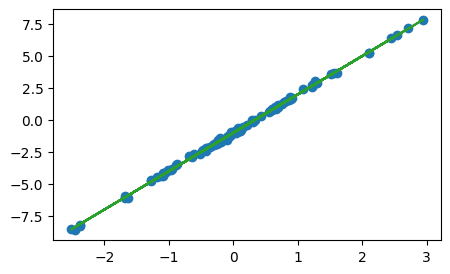

In [28]:
xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = 3 * xs - 1 + noise

def model(theta, x):
    w, b = theta
    return w * x + b

def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)

@jit# jit is WAY faster
def update(theta, x, y, lr=0.1):
    return theta - lr * grad(loss_fn, argnums=0)(theta, x, y)

theta = jnp.array([1., 1.])

for _ in range(10000):
    theta = update(theta, xs, ys)

plt.figure(figsize=(5,3))
plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs), color="tab:green")
plt.show()

## Simple NN

Notes:
- We define forward model for a single image example, and use JAX’s `vmap` function to automatically handle mini-batches, with no performance penalty.
- We use the whole of the JAX API: `grad` for derivatives, `jit` for speedups, `vmap` for auto-vectorization, `jnp` to specify all of our computation, data loaders from PyTorch, and run on the GPU.

In [29]:
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
    # PER EXAMPLE predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

batched_predict = vmap(predict, in_axes=(None, 0))

def loss(params, images, targets):
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

@jit# just jit the whole thing!
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return [(w - step_size * dw, b - step_size * db) for (w, b), (dw, db) in zip(params, grads)]

#for epoch in range(num_epochs):
#    for x, y in dataloader:
#    params = update(params, x, y)


layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))